# <center> Innoscape - Telecom Paristech - Projet fil rouge </center>
# <center> Catégorisation des produits </center>

L'objet de ce notebook est de comparer plusieurs approches pour le retrait de produits potentiellement ambigus, de manière à accroître la performance du modèle de catégorisation des produits.

In [5]:
# Import librairies 
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.externals import joblib

# IMPORT MODULES PREPROCESSING
from preprocessing import *
from load_data import *

# SET OPTIONS
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# SET PATH
chemin = "../../Data/"

## Import dataset + Preprocessing

In [37]:
# Load seller data preprocessed (avoid long preprocessing time)
df_seller = pd.read_csv(chemin + "t3_all_fr_prices_posweekly_prod_without_price_preprocessed.csv").iloc[:, 7:]
df_seller.fillna("", inplace=True)

In [38]:
df_seller.head(5)

productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
1                                                         
2                                                         
3                     mastic                     mastic   
4                       cire                       cire   

  prodcategory3_seller_clean     prodcategory2_seller_clean  \
0              colle adhesif                  quincaillerie   
1                                                             
2  vaisselle accessoire lave                     accessoire   
3              colle adhesif                  quincaillerie   
4  teinture peinture solvant  peinture outil traitement mur   

  prodcategory1_seller_clean  \
0                  bricolage   
1                              
2        electromenager gros   
3                  bricolage   
4                  bricolage   

                            productseller_name_clean  
0  max blanc exterieur carreau xtra interieur col...  
1                    scaldabagno heure pro elettrico  
2  couvercle laver vaisselle compartiment panier ...  
3                      etancheite mastic colle joint  
4           mat sol impermeabiliser effet protection

In [24]:
# Chargement du csv labellisé avec les colonnes sélectionnées (dans notre cas : prodcategory1-2-3-4 + product family + description +label)
df_train = load_data(chemin + "data_categorization.csv", columns_to_keep=[0, 1, 2, 3, 4, 5, 6, 7])
# Preprocessing
df_train_all = preprocessing(df_train, df_train.columns[:-2], stop_words, tag_dir="C:/TreeTagger") # Put treetagger library directory
# Get back label data
df_train_all["label"] = df_train["label"].copy()
df_train_all["label_name"] = df_train["label_name"].copy()

In [16]:
df_train_all.head(5)

productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
1                     mastic                     mastic   
2                       cire                       cire   
3   perceur visseur|visseuse                    perceur   
4         produit etancheite         produit etancheite   

  prodcategory3_seller_clean      prodcategory2_seller_clean  \
0              colle adhesif                   quincaillerie   
1              colle adhesif                   quincaillerie   
2  teinture peinture solvant   traitement mur peinture outil   
3  electroportatif outillage  main electroportatif outillage   
4              colle adhesif                   quincaillerie   

  prodcategory1_seller_clean  \
0                  bricolage   
1                  bricolage   
2                  bricolage   
3                  bricolage   
4                  bricolage   

                            productseller_name_clean  label  \
0  xtra carreau interieur max sikaceram coller bl...     27   
1                      mastic etancheite joint colle     27   
2  sikagard protection mat sol impermeabiliser effet     27   
3  chargeur rcd sac oneplus perceur lithium batte...     62   
4  bander cuit etancheite resistant multiseal aut...     27   

                                   label_name  
0                   mastic, colle, étanchéité  
1                   mastic, colle, étanchéité  
2                   mastic, colle, étanchéité  
3  perceuse, perforateur et visseuse sans fil  
4                   mastic, colle, étanchéité

## Etude de l'influence du paramètre "max features" lors de la transformation en tf-idf:

On commence par regrouper toutes les données textuelles (catégories vendeurs + description) dans une seule colonne de texte:

In [39]:
df_train_all['concat'] = df_train_all['productfamily_seller_clean'] + ' ' + \
                     df_train_all['prodcategory4_seller_clean'] + ' ' + \
                     df_train_all['prodcategory3_seller_clean'] + ' ' + \
                     df_train_all['prodcategory2_seller_clean'] + ' ' + \
                     df_train_all['prodcategory1_seller_clean'] + ' ' + \
                     df_train_all['productseller_name_clean']

On retire ensuite les familles dont les effectifs sont trop faibles pour entraîner un classifieur:

In [40]:
fam_counts = df_train_all.groupby('label').count()['productfamily_seller_clean']
main_fams = list(fam_counts[fam_counts>20].index.values)
df_train_main_fams = df_train_all[df_train_all['label'].isin(main_fams)]

On effectue un tf-idf sur l'ensemble du corpus:

In [41]:
df_seller['concat'] = df_seller['productfamily_seller_clean'] + ' ' + \
                     df_seller['prodcategory4_seller_clean'] + ' ' + \
                     df_seller['prodcategory3_seller_clean'] + ' ' + \
                     df_seller['prodcategory2_seller_clean'] + ' ' + \
                     df_seller['prodcategory1_seller_clean'] + ' ' + \
                     df_seller['productseller_name_clean']

In [46]:
n_top_words = list(np.arange(50,550,50))+list(np.arange(500,7500,500))
scores = []

%time
for element in n_top_words:
    #calcul des tf-idf
    vectorizer = TfidfVectorizer(max_features = element)
    tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_seller["concat"]))
    
    #constitution d'un train set et d'un test set:
    X = pd.DataFrame(tf_idf_total.todense()).set_index(df_seller.index.values).loc[df_train_main_fams.index]
    Y = df_train_main_fams["label"].values
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y,test_size=0.2, random_state = 548)
    
    #entraînement d'un classifieur sur le train set et calcul du score
    etc = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
    etc.fit(Xtrain,Ytrain)
    scores.append(etc.score(Xtest,Ytest))
    

#affichage des résultats:
chart = plt.plot(n_top_words, scores)
plt.xlabel('taille du vocabulaire utilisé pour calculer les tf-idf')
plt.ylabel('score du modèle de classification')
plt.title('influence du paramètre "max_features" sur la précision')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.set_xscale('log')
chart2 = plt.plot(n_top_words, scores)
plt.xlabel('taille du vocabulaire utilisé pour calculer les tf-idf')
plt.ylabel('score du modèle de classification')
plt.title('influence du paramètre "max_features" sur la précision')
plt.show()

## Embedding - NMF 250

On reprend la totalité du corpus existant:

In [13]:
num_top_words = 500
vectorizer = TfidfVectorizer(max_features = num_top_words)
tf_idf_total = sparse.csr_matrix(vectorizer.fit_transform(df_seller["concat"]))
vectorizer.get_feature_names()

['abergement',
 'about',
 'accessoire',
 'acier',
 'acrylique',
 'adherence',
 'adhesif',
 'adjuver',
 'aerateur',
 'aeration',
 'aerosol',
 'air',
 'alde',
 'alimentation',
 'alu',
 'aluminium',
 'amarante',
 'ancien',
 'angle',
 'angulaire',
 'anthracite',
 'anti',
 'ardoise',
 'ardoiser',
 'aretier',
 'arret',
 'arrosage',
 'aspirateur',
 'atelier',
 'atlantique',
 'auto',
 'autocollant',
 'autoporte',
 'autre',
 'avoir',
 'bain',
 'ballon',
 'bande',
 'bandeau',
 'bander',
 'bardage',
 'bardelis',
 'barre',
 'batiment',
 'batterie',
 'bavette',
 'beige',
 'beton',
 'bidon',
 'blanc',
 'bois',
 'boite',
 'bordure',
 'bourgogne',
 'bourrelet',
 'bpe',
 'branche',
 'brande',
 'brico',
 'bricolage',
 'briser',
 'broyeur',
 'brun',
 'burineur',
 'cacher',
 'canal',
 'canisse',
 'carrelage',
 'cartouche',
 'castelviel',
 'chaine',
 'champagne',
 'chapeau',
 'charentais',
 'chargeur',
 'charpente',
 'chatiere',
 'chaud',
 'chauffage',
 'chauffe',
 'chaux',
 'chene',
 'chevreuse',
 'chimie

In [ ]:
# Embedding NMF
nmf = NMF(n_components=250, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total)

In [14]:
# SAVE & LOAD Model to avoid unecessary comput time
#joblib.dump(nmf, "nmf_250topics_20190408.save") 
nmf = joblib.load("nmf_250topics_20190408.save") 

In [19]:
X = pd.DataFrame(nmf.transform(tf_idf_total.todense())).set_index(df_seller.index.values).loc[df_train_main_fams.index]
X.rename(columns=dict(zip(range(250),['topic_'+str(i) for i in range(250)])),inplace=True)
Y = df_train_main_fams['label_name']
df_topics = df_train_main_fams.merge(X, how='inner', left_index=True, right_index=True)
df_topics['label_name'] = Y
df_topics[['productfamily_seller','productseller_name','label_name']].head()

productfamily_seller                                 productseller_name  \
0     Colles à carrelage  SikaCeram Xtra   Colle à carrelage intérieur e...   
3                 Mastic              Colle mastic pour joints d étanchéité   
4                  Cires  Sikagard Protection Sol MAT   Imperméabilisant...   
6      Perceuse visseuse  Perceuse visseuse RYOBI 18V OnePlus   1 batter...   
7  Produits d étanchéité  Sika Multiseal   Bande d étanchéité autocollan...   

                     Product_family_innoscape  
0                   mastic, colle, étanchéité  
3                   mastic, colle, étanchéité  
4                   mastic, colle, étanchéité  
6  perceuse, perforateur et visseuse sans fil  
7                   mastic, colle, étanchéité

### Etude des top topics par famille

On peut à présent étudier la distribution des poids des top topics sur le dataset.Voyons d'abord comment se répartit la somme des poids des produits sur l'échantillon:

C:\Users\JN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


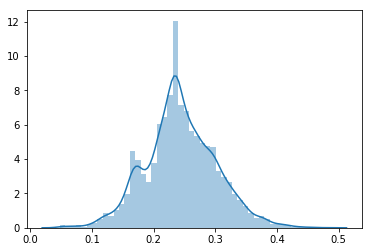

In [20]:
col_names = ['topic_'+str(i) for i in range(250)]
weights = df_topics[col_names]
total_weights = np.sum(weights, axis=1)
chart = sns.distplot(total_weights)

df_topics['total_weights'] = total_weights

On remarque que la NMF ne semble pas effectuer de normalisation des poids (ie mettre le total des coefficients à 1). Qui plus est, on observe qu'une petite minorité de produits a des poids extrêment faibles sur tous les topics, et ne sont donc pas correctement décrits par l'embedding retenu. On va donc normaliser les poids des topics.

On définit ensuite quelques fonctions pour identifier les principaux topics associés à un produit et leurs coefficients:

In [21]:
def get_top_topics(row, num_topics, num_top_topics):
    cols_to_fetch = ['topic_'+str(i) for i in range(num_topics)]
    top_topics_idx = np.argsort(-np.array(row[cols_to_fetch]))[:num_top_topics]
    top_topics_cols = ['topic_'+str(i) for i in top_topics_idx]
    top_topics_weights = row[top_topics_cols].values
    return [top_topics_idx,top_topics_weights]

In [22]:
def unpack_top_topics(df, top_topics_col,total_weights_col ,num_top_topics):
    col_names1 = ['top_topic_'+str(i) for i in range(1,num_top_topics+1)]
    col_names2 = ['top_topic_'+str(i)+'_relative_weight' for i in range(1,num_top_topics+1)]
    df2 = df.copy()
    for i in range(len(col_names1)):
        df2[col_names1[i]] = df[top_topics_col].apply(lambda x: x[0][i])
        df2[col_names2[i]] = df[top_topics_col].apply(lambda x: x[1][i])
        df2[col_names2[i]] = df2[col_names2[i]]/df2[total_weights_col]
    return df2

In [47]:
num_topics = 250
num_top_topics = 10
df_topics['top_top'] = df_topics.apply(get_top_topics, args=([250,num_top_topics]), axis=1)
df_topics = unpack_top_topics(df_topics,'top_top','total_weights', num_top_topics)
df_topics.drop('top_top', axis=1, inplace=True)
df_topics.head()

productfamily_seller   prodcategory4_seller  \
0     Colles à carrelage     Colles à carrelage   
3                 Mastic                 Mastic   
4                  Cires                  Cires   
6      Perceuse visseuse              Perceuses   
7  Produits d étanchéité  Produits d étanchéité   

              prodcategory3_seller                     prodcategory2_seller  \
0               Colles et adhésifs                            Quincaillerie   
3               Colles et adhésifs                            Quincaillerie   
4  Peintures teintures et solvants  Peintures outils et traitement des murs   
6        Outillage électroportatif      Outillage à main et électroportatif   
7               Colles et adhésifs                            Quincaillerie   

  prodcategory1_seller                                 productseller_name  \
0            Bricolage  SikaCeram Xtra   Colle à carrelage intérieur e...   
3            Bricolage              Colle mastic pour joints d étanchéité   
4            Bricolage  Sikagard Protection Sol MAT   Imperméabilisant...   
6            Bricolage  Perceuse visseuse RYOBI 18V OnePlus   1 batter...   
7            Bricolage  Sika Multiseal   Bande d étanchéité autocollan...   

  productfamily_seller_clean prodcategory4_seller_clean  \
0            colle carrelage            colle carrelage   
3                     mastic                     mastic   
4                       cire                       cire   
6   perceur visseur|visseuse                    perceur   
7         etancheite produit         etancheite produit   

  prodcategory3_seller_clean      prodcategory2_seller_clean  \
0              colle adhesif                   quincaillerie   
3              colle adhesif                   quincaillerie   
4  teinture peinture solvant   peinture outil traitement mur   
6  outillage electroportatif  outillage electroportatif main   
7              colle adhesif                   quincaillerie   

  prodcategory1_seller_clean  \
0                  bricolage   
3                  bricolage   
4                  bricolage   
6                  bricolage   
7                  bricolage   

                            productseller_name_clean  \
0  max blanc exterieur carreau xtra interieur col...   
3                      etancheite mastic colle joint   
4           mat sol impermeabiliser effet protection   
6  oneplus visseur|visseuse lithium perceur batte...   
7  etancheite dechirure cuit terre bander autocol...   

                                              concat  \
0  colle carrelage colle carrelage colle adhesif ...   
3  mastic mastic colle adhesif quincaillerie bric...   
4  cire cire teinture peinture solvant peinture o...   
6  perceur visseur|visseuse perceur outillage ele...   
7  etancheite produit etancheite produit colle ad...   

                     Product_family_innoscape  topic_0  topic_1   topic_2  \
0                   mastic, colle, étanchéité      0.0      0.0  0.015388   
3                   mastic, colle, étanchéité      0.0      0.0  0.025231   
4                   mastic, colle, étanchéité      0.0      0.0  0.000000   
6  perceuse, perforateur et visseuse sans fil      0.0      0.0  0.000000   
7                   mastic, colle, étanchéité      0.0      0.0  0.019414   

   topic_3   topic_4  topic_5  topic_6  topic_7  topic_8   topic_9  topic_10  \
0      0.0  0.000000      0.0      0.0      0.0      0.0  0.000000       0.0   
3      0.0  0.000000      0.0      0.0      0.0      0.0  0.000000       0.0   
4      0.0  0.026948      0.0      0.0      0.0      0.0  0.015652       0.0   
6      0.0  0.000000      0.0      0.0      0.0      0.0  0.000000       0.0   
7      0.0  0.001260      0.0      0.0      0.0      0.0  0.000000       0.0   

   topic_11  topic_12  topic_13  topic_14  topic_15  \
0  0.000000       0.0  0.022128       0.0       0.0   
3  0.027414       0.0  0.000000       0.0       0.0   
4  0.000000       0.0  0.000000       0.0  

Pour déterminer combien de topics permettent en moyenne de caractériser un produit, voyons à présent la distribution moyenne des poids des principaux topics: 

C:\Users\JN\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


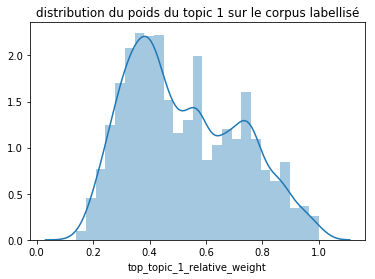

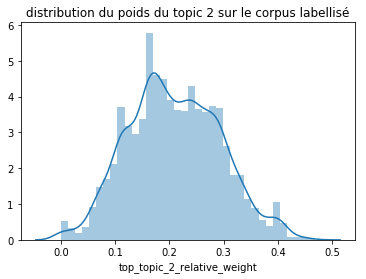

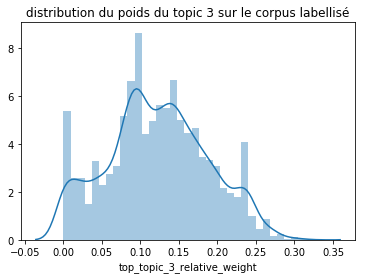

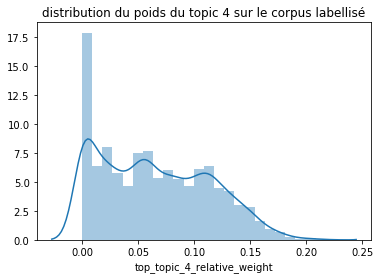

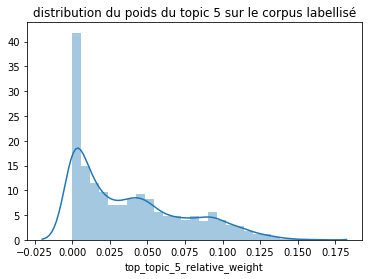

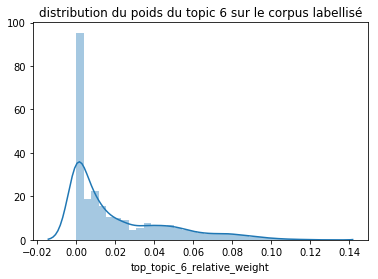

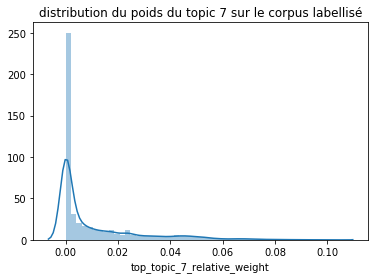

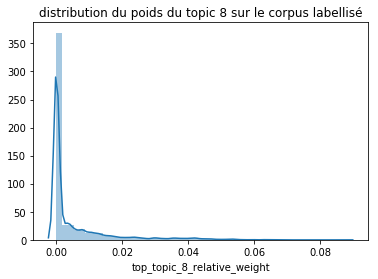

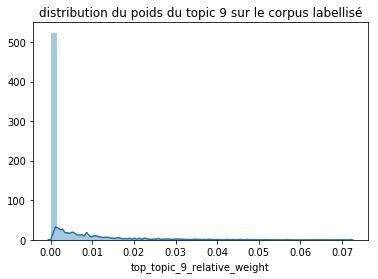

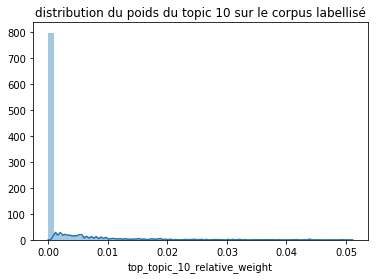

In [48]:
for i in range(num_top_topics) :
    sns.distplot(df_topics['top_topic_'+str(i+1)+'_relative_weight'])
    plt.title('distribution du poids du topic '+str(i+1)+' sur le corpus labellisé')
    plt.show()

On voit ainsi qu'une majorité de produits peut être caractérisée par les deux premiers topics, représentant généralement près de 60% du poids des topics. Voyons à présent, pour chaque famille de produits, quels sont les topics qui reviennent le plus souvent dans les deux 1ers topics:

In [49]:
topics_by_fam = df_topics.groupby('label_name').sum()
topics_by_fam = topics_by_fam[col_names]
total_weights = np.sum(topics_by_fam, axis=1)
topics_by_fam['total_weights'] = total_weights
topics_by_fam['top_top'] = topics_by_fam.apply(get_top_topics, args=([250,3]), axis=1)
topics_by_fam = unpack_top_topics(topics_by_fam,'top_top','total_weights', 3)

topics_by_fam[['top_topic_1','top_topic_1_relative_weight','top_topic_2','top_topic_2_relative_weight']].head(50)

top_topic_1  \
Product_family_innoscape                                          
accessoires chauffe-eau                                      12   
accessoires couverture                                      230   
accessoires et consommables outillage électropo...          137   
accessoires pour nettoyeur haute pression                   197   
accessoires pour outillage motorisé                         175   
ampoules et leds                                            174   
aménagements décoratifs                                      72   
anti-mousse                                                 248   
arrosage                                                     77   
aspirateurs, souffleurs, broyeurs                           103   
aérateur et vmc                                              88   
bardage                                                       4   
barre de seuil et nez de marche                              61   
batterie et chargeur                                         17   
brise-vue, canisse, brande, grillage et brise vent           58   
chauffage                                                   136   
chauffe-eau gaz                                             193   
chauffe-eau électrique                                       12   
conduit et accessoires d'aération                            20   
contenants                                                  211   
couverture                                                   14   
disjoncteur, coupe-circuit et interrupteur diff...           91   
divers                                                      134   
divers oep                                                  226   
débroussailleuse et coupe-bordures                           52   
défonceuse et lamelleuse et rabot                           154   
gouttière, descente et accessoires                            9   
grillage avertisseur et gaine de protection                   5   
mastic, colle, étanchéité                                    13   
meuleuse et rainureuse                                       24   
motobineuses et motoculteurs                                171   
mousse expansive                                            181   
outil motorisé modulable                                    175   
outillage à main                                            205   
outils multifonctions                                        37   
peinture                                                      6   
perceuse, perforateur et visseuse filaire                   153   
perceuse, perforateur et visseuse sans fil                   10   
pince et tenaille                                           190   
pistolet à colle et agrafeuse                               217   
plinthe bois, plinthe mdf, plinthe pvc                      241   
ponceuse électrique                                          33   
poudre béton, chaux, ciment, enduit, mortier, r...           59   
protection jardin, paillage, tuteurs et accesso...          227   
scies électriques                                            71   
taille-haies                                                 48   
tondeuses electriques, thermiques et autoportée               7   
tournevis (cruciforme, aimanté, de précision…)              165   
tronçonneuse, scie et fendeur de bois                        41   
vidage, bonde et siphon                                     220   

                                                    top_topic_1_relative_weight  \
Product_family_innoscape                                                          
accessoires chauffe-eau                                                0.474915   
accessoires couverture                                                 0.127009   
accessoires et consommables outillage électropo...                     0.090216   
accessoires pour nettoyeur haute pression                              0.147798   
accessoires pour outillage motorisé                                  

On va tout d'abord s'assurer qu'aucune paire de topics ne caractérise deux familles différentes:

In [50]:
topics_by_fam.shape[0]

50

In [51]:
top_topics_by_fam = topics_by_fam[['top_topic_1','top_topic_2']]
top_topics_by_fam.drop_duplicates()
top_topics_by_fam.shape[0]

50

On voit ainsi qu'il n'y a pas de doublons. Tâchons à présent de voir dans quelle mesure:
    - les topics ci-dessus sont bien caractéristiques de certaines familles de produits
    - ces topics sont expressifs (ie concentrés sur un faible nombre de mots, formant un ensemble cohérent)

Tout d'abord, voyons, pour chacun de ces topics, dans combien de familles il apparaît dans le top 2:

In [52]:
from collections import Counter

topic_list = list(topics_by_fam['top_topic_1'])+list(topics_by_fam['top_topic_2'])
occurrences = dict(Counter(topic_list))
frequent_topics = [k for (k,v) in occurrences.items() if v>=2]
len(frequent_topics)

16

Voyons quels sont les topics concernés, et à quel vocabulaire et à quelles familles ils se rapportent:

In [53]:
#extraction des composantes des topics dans l'espace du tf-idf:
topics_raw = nmf.components_

#correspondance des composantes en langage naturel
voc = vectorizer.vocabulary_
voc_reverse = dict(zip(voc.values(),voc.keys()))

#extraction des n premières composantes de chaque topic:
n_top = 6
topic_description = {}

for i in range(topics_raw.shape[0]):
    top_components = np.argsort(-topics_raw[i,:])[:n_top]
    weights = topics_raw[i,top_components]
    words = [voc_reverse[c] for c in top_components]
    explanation = dict(zip(words,weights))
    topic_description[i] = explanation

In [54]:
#recensement des familles dans lesquelles apparaissent les topics fréquents:
for t in frequent_topics:
    fams = list(topics_by_fam[topics_by_fam['top_topic_1']==t].index)+ \
        list(topics_by_fam[topics_by_fam['top_topic_2']==t].index)
    print('topic_'+str(t)+':')
    print()
    for f in fams:
        print(f)
    print(topic_description[t])
    print('_'*30)
    print()

topic_12:

accessoires chauffe-eau
chauffe-eau électrique
chauffe-eau gaz
{'chauffe': 5.608099980457248, 'eau': 4.298298898698899, 'plomberie': 1.5434085365440837, 'ballon': 0.44893476277361327, 'steatite': 0.42291345000214514, 'securite': 0.2534040435408444}
______________________________

topic_175:

accessoires pour outillage motorisé
outil motorisé modulable
{'motoriser': 2.5093653584535596, 'modulable': 2.3748561962138286, 'outil': 2.1892528191391976, 'tailler': 0.6526515603360751, 'terrasser': 0.5950656737949988, 'jardin': 0.5944417012368184}
______________________________

topic_136:

chauffage
accessoires chauffe-eau
chauffe-eau électrique
{'chaud': 3.2905479630025942, 'production': 2.803562205348823, 'eau': 1.5948239700140043, 'ballon': 0.5443662149269616, 'mural': 0.5357932796856809, 'plomberie': 0.3712390682160971}
______________________________

topic_226:

divers oep
tondeuses electriques, thermiques et autoportée
{'thermique': 3.7523494029731443, 'cm³': 0.257250087297293,

Voyons à présent s'il existe des topics peu concentrés autour de leurs premiers mots. Pour cela, voyons comment se répartissent en moyenne les poids des mots des topics.

In [55]:
topic_components = pd.DataFrame(topics_raw)
topic_components['total'] = np.sum(topic_components, axis=1)

#voyons déjà s'il existe des topics qui ne contiennent aucun mot, et retirons-les:
empty_topics = topic_components[topic_components['total']==0].index
topic_components.drop(empty_topics, axis=0, inplace=True)

In [56]:
topic_components.shape

(190, 501)

In [57]:
#normalisation des poids des mots:
for i in range(num_top_words):
    topic_components[i] = topic_components[i]/topic_components['total']

In [58]:
empty_topics

Int64Index([ 26,  28,  30,  31,  49,  64,  65,  66,  68,  69,  70,  73,  74,
             78,  79,  80,  81,  82,  87,  89,  92,  94,  96,  97,  98, 100,
            101, 107, 108, 109, 111, 112, 113, 114, 119, 120, 124, 127, 129,
            130, 135, 138, 139, 140, 143, 144, 145, 148, 149, 152, 157, 158,
            161, 162, 170, 172, 180, 187, 189, 202],
           dtype='int64')

In [61]:
total_cum_weights

array([0.01168217, 0.01168805, 0.01168805])

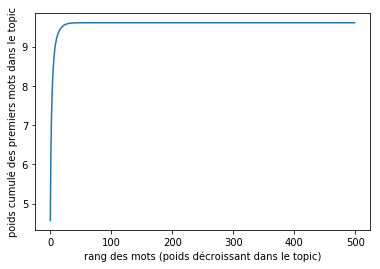

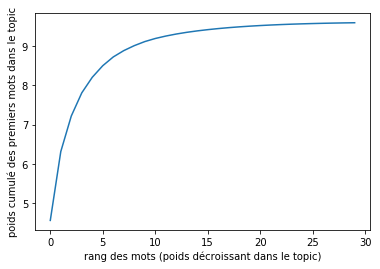

In [68]:
#tri des poids de chaque topic:
#initialisation:
coeffs_sorted = -np.sort(-topic_components.loc[0, range(num_top_words)])

#tri
for i in range(1,num_topics):
    if i in empty_topics:
        pass
    else:
        coeffs_sorted = np.vstack((coeffs_sorted, -np.sort(-topic_components.loc[i, range(num_top_words)])))

#calcul des poids cumulés et agrégation:
cum_weights = np.cumsum(coeffs_sorted, axis=1)
total_cum_weights = np.sum(cum_weights, axis=0)/cum_weights.shape[0]

#affichage des résultats:
# fig, ax = plt.subplots()
# ax.set_xscale('log')
plt.plot(range(num_top_words),total_cum_weights)
plt.xlabel('rang des mots (poids décroissant dans le topic)')
plt.ylabel('poids cumulé des premiers mots dans le topic')
plt.show()

#pour visualiser plus clairement, on se concentre sur les 100 mots principaux:
plt.plot(range(30),total_cum_weights[:30])
plt.xlabel('rang des mots (poids décroissant dans le topic)')
plt.ylabel('poids cumulé des premiers mots dans le topic')
plt.show()

Au vu de ce qui précède, il paraît raisonnable d'exclure de l'analyse tous les topics dont les 3 premiers mots représentent moins de 70% des coefficients:

In [242]:
topic_components[list(range(500))]

0         1         2         3         4         5         6    \
0    0.0  0.000089  0.000000  0.000000  0.000000  0.000000  0.000000   
1    0.0  0.000000  0.064308  0.000000  0.000000  0.000000  0.000000   
2    0.0  0.000000  0.000000  0.000000  0.000000  0.032263  0.000000   
3    0.0  0.000000  0.093584  0.000000  0.000000  0.000000  0.000000   
4    0.0  0.000000  0.000000  0.000000  0.220546  0.000000  4.940142   
5    0.0  0.000000  0.000886  0.002233  0.000000  0.021779  0.000000   
6    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7    0.0  0.000000  0.000000  0.021442  0.000000  0.000000  0.000000   
8    0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9    0.0  0.000000  0.077047  0.000000  0.000000  0.000000  0.000000   
10   0.0  0.000000  0.004985  0.000000  0.000000  0.000000  0.000000   
11   0.0  0.000000  0.000000  0.000000  0.000000  0.063241  0.027417   
12   0.0  0.000000  0.005085  0.000000  0.000000  0.000000  0.000000   
13   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
14   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
15   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
16   0.0  0.000000  0.065132  0.000000  0.000000  0.000000  0.000000   
17   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
18   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
19   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
20   0.0  0.000000  0.082014  0.107082  0.000000  0.000000  0.000000   
21   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
22   0.0  0.000000  0.000000  0.021885  0.000000  0.000000  0.000000   
23   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
24   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
27   0.0  0.000000  0.002156  0.000000  0.000000  0.000000  0.000000   
29   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
32   0.0  0.000000  0.000000  0.000000  0.003770  0.000000  0.000000   
33   0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..   ...       ...       ...       ...       ...       ...       ...   
220  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
221  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
222  0.0  0.000000  0.000000  0.000000  0.024616  0.000000  0.000000   
223  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
224  0.0  0.000000  0.000000  0.000000  0.020259  0.000000  0.000000   
225  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
226  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
227  0.0  0.000000  0.026374  0.000000  0.000000  0.000000  0.000000   
228  0.0  0.000000  0.000000  0.000000  0.000000  0.032105  0.000000   
229  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
230  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.017133   
231  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
232  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
233  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
234  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
235  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
236  0.0  0.742919  0.000000  0.000000  0.000000  0.000000  0.000000   
237  0.0  0.000000  0.005677  0.000000  0.000000  0.000000  0.000000   
238  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
239  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.838375   
240  0.0  0.000000  0.000000  3.785167  0.000000  0.000000  0.000000   
241  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
242  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
243  0.0  0.000000  0.000000  0.000000  0.000

Identification des topics trop peu concentrés autour de leurs principaux mots :

In [259]:
def get_nb_relevant_items(row, threshold):
    """ donne, pour un produit donné, le nombre de topics pertinents """
    counter = 1
    for i in range(1, row.shape[0]):
        if row.iloc[i] / row.iloc[i - 1] >= threshold:
            counter += 1
        else:
            break
            
    return counter

def get_top_words(row, num_words, num_top_words):
    """ renvoie la liste des mots, triés par poids décroissants, et les poids """
    cols_to_fetch = [i for i in range(num_words)]
    top_words_idx = np.argsort(-np.array(row[cols_to_fetch]))[:num_top_words]
    top_words_cols = [i for i in top_words_idx]
    top_words_weights = row[top_words_cols].values
    return [top_words_idx,top_words_weights]

def unpack_top_words(df, top_words_col,total_weights_col ,num_top_words):
    """ extrait les k premiers mots d'un topic et leurs poids respectifs dans des colonnes distinctes """
    col_names1 = ['top_word_'+str(i) for i in range(1,num_top_words+1)]
    col_names2 = ['top_word_'+str(i)+'_relative_weight' for i in range(1,num_top_words+1)]
    df2 = df.copy()
    for i in range(len(col_names1)):
        df2[col_names1[i]] = df[top_words_col].apply(lambda x: x[0][i])
        df2[col_names2[i]] = df[top_words_col].apply(lambda x: x[1][i])
        df2[col_names2[i]] = df2[col_names2[i]]/df2[total_weights_col]
    return df2

In [261]:
# réalisation d'un dataframe des principaux mots par topic, analogue à celui des principaux topics par produit:
num_top_words = 20
dfw = topic_components.copy()
dfw['top_words'] = dfw.apply(get_top_words, args=([500,num_top_words]), axis=1)
dfw = unpack_top_words(dfw,'top_words','total', num_top_words)
dfw.drop('top_words', axis=1, inplace=True)
dfw.head()

0         1         2    3         4         5         6    7    8    9  \
0  0.0  0.000089  0.000000  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0   
1  0.0  0.000000  0.064308  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0   
2  0.0  0.000000  0.000000  0.0  0.000000  0.032263  0.000000  0.0  0.0  0.0   
3  0.0  0.000000  0.093584  0.0  0.000000  0.000000  0.000000  0.0  0.0  0.0   
4  0.0  0.000000  0.000000  0.0  0.220546  0.000000  4.940142  0.0  0.0  0.0   

         10   11   12   13        14   15   16   17        18   19        20  \
0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
1  0.000000  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.005915  0.0  0.025578   
2  0.003596  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.000000  0.0  0.000000   
3  0.000000  0.0  0.0  0.0  0.029657  0.0  0.0  0.0  0.273523  0.0  0.061314   
4  0.390613  0.0  0.0  0.0  0.048631  0.0  0.0  0.0  0.000000  0.0  0.019397   

    21        22   23   24   25   26   27   28        29  \
0  0.0  0.741410  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
1  0.0  0.417393  0.0  0.0  0.0  0.0  0.0  0.0  0.035952   
2  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
3  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
4  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

              ...               top_word_6  top_word_6_relative_weight  \
0             ...                      132                    0.001936   
1             ...                      273                    0.084027   
2             ...                      433                    0.005964   
3             ...                      458                    0.031173   
4             ...                      362                    0.033992   

   top_word_7  top_word_7_relative_weight  top_word_8  \
0         434                    0.001657         134   
1          22                    0.017305         469   
2         281                    0.005236         365   
3         320                    0.023167         193   
4          10                    0.017325          81   

   top_word_8_relative_weight  top_word_9  top_word_9_relative_weight  \
0                    0.001433         437                    0.001242   
1                    0.015154         118                    0.007780   
2                    0.004990           5                    0.003818   
3                    0.017794         155                    0.014867   
4                    0.014249         250                    0.014138   

   top_word_10  top_word_10_relative_weight  top_word_11  \
0           76                     0.001228          390   
1          228                     0.005827          336   
2          230                     0.003434          417   
3          301                     0.014735           18   
4          255                     0.013060          145   

   top_word_11_relative_weight  top_word_12  top_word_12_relative_weight  \
0                     0.001149           56                     0.000936   
1                     0.004021          397                     0.003776   
2                     0.002829          223                     0.002729   
3                     0.013322          112                     0.013089   
4                     0.012869            4                     0.009782   

   top_word_13  top_word_13_relative_weight  top_word_14  \
0          144                     0.000886          138   
1            2                     0.002666           45   
2          468                     0.001980          426   
3          118                     0.012479          387   
4           50                     0.009486          271   

   top_word_14_relative_weight  top_word_15  top_word_15_relative_weight  \
0                     0.000838          188                     0.000645   
1                     0.002286          122                     0.002128   
2                     0.001648          341     

In [264]:
df_topics.columns

Index(['productfamily_seller', 'prodcategory4_seller', 'prodcategory3_seller',
       'prodcategory2_seller', 'prodcategory1_seller', 'productseller_name',
       'productfamily_seller_clean', 'prodcategory4_seller_clean',
       'prodcategory3_seller_clean', 'prodcategory2_seller_clean',
       ...
       'top_topic_6_relative_weight', 'top_topic_7',
       'top_topic_7_relative_weight', 'top_topic_8',
       'top_topic_8_relative_weight', 'top_topic_9',
       'top_topic_9_relative_weight', 'top_topic_10',
       'top_topic_10_relative_weight', 'nb_relevant_topics'],
      dtype='object', length=286)

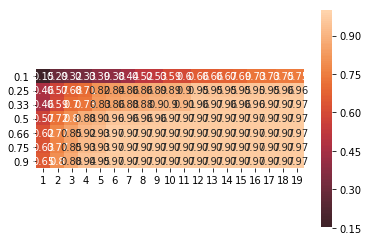

In [266]:
# on spécifie la liste des colonnes où sont stockés les produits
#col_list = list(range(num_top_words))
col_list = ['top_word_'+str(i+1) for i in range(num_top_words)]

thresholds = [0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9]
max_nb_relevant_words = range(1,20)
scores = np.zeros((len(thresholds), len(max_nb_relevant_words)))
topic_components_sorted = pd.DataFrame(coeffs_sorted)

for i in range(len(thresholds)):
    threshold = thresholds[i]
    # on extrait, pour chaque topic, le nombre de mots pertinents
    dfw['nb_relevant_words'] = dfw[col_list].apply(
        get_nb_relevant_items, args=([threshold]), axis=1)

    # on élimine les topics qui ont trop de mots significatifs et on affiche l'impact sur la performance :
    for j in range(len(max_nb_relevant_words)):
        element = max_nb_relevant_words[j]
        diffuse_topics = dfw[dfw['nb_relevant_words'] > element].index
        prods_to_drop = [idx for idx in df_topics.index if df_topics.loc[idx,'top_topic_1'] in diffuse_topics]
        prods_to_drop = [k for k in Xtrain.index if k in prods_to_drop]
        Xtrain_red = Xtrain.drop(prods_to_drop)
        Ytrain_red = Ytrain.drop(prods_to_drop)
        etc = ExtraTreesClassifier(max_depth=100,
                                   random_state=42,
                                   n_estimators=2000,
                                   n_jobs=-1)
        etc.fit(Xtrain_red, Ytrain_red)
        scores[i, j] = etc.score(Xtest, Ytest)

# mise en forme des résultats dans un dataframe et affichage
scores = pd.DataFrame(scores, index=thresholds).rename(columns=
    dict(zip(range(len(max_nb_relevant_topics)), max_nb_relevant_topics))
)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(scores, vmax=1, center=0,
            square=True, annot=True)

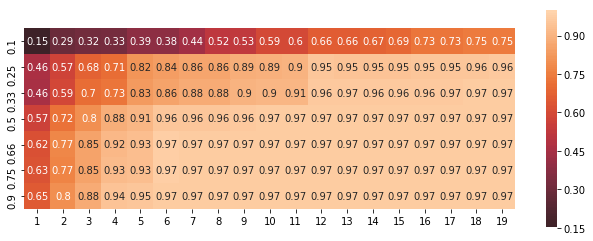

In [269]:
f, ax = plt.subplots(figsize=(11,4))
sns.heatmap(scores, vmax=1, center=0,
            square=True, annot=True)

On observe ainsi que retirer les produits dont le topic principal est un topic dont les 6 premiers mots concentrent moins de 66% du poids total de ses mots ne dégrade pas la performance du modèle. Voyons quel est l'effectif minimal par catégorie après retrait des produits correspondants :

In [271]:
dfw['nb_relevant_words'] = dfw[col_list].apply(
        get_nb_relevant_items, args=([threshold]), axis=1)

diffuse_topics = dfw[dfw['nb_relevant_words'] > 6].index
prods_to_drop = [idx for idx in df_topics.index if df_topics.loc[idx,'top_topic_1'] in diffuse_topics]
prods_to_drop = [k for k in Xtrain.index if k in prods_to_drop]

recap = df_topics.drop(prods_to_drop, axis=0)
recap = recap.groupby('Product_family_innoscape').count()
min(recap.productfamily_seller)

21

Pas de problème d'effectifs ; voyons l'impact sur la performance du modèle :

In [275]:
X_red = X.drop(prods_to_drop)
Y_red = Y.drop(prods_to_drop)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_red,Y_red,test_size=0.2, random_state = 42,stratify=Y_red)
    
#entraînement d'un classifieur sur le train set et calcul du score
etc_red = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_red.fit(Xtrain,Ytrain)
score_red = etc_red.score(Xtest,Ytest)
print(score_red)

0.9668820678513732


La performance semble diminuer légèrement.

In [69]:
# num_main_words = 3
# threshold = 0.7
# indices  = [i for i in range(num_topics) if i not in empty_topics]
# weights_top_words = pd.Series(cum_weights[:,num_main_words], index= indices)
# #weights_top_words['total']=np.sum(weights_top_words, axis=1)
# diffuse_topics = weights_top_words[weights_top_words<threshold].index
# diffuse_topics

Int64Index([], dtype='int64')

Voyons plus en détail ce que contiennent ces topics:

In [284]:
for t in diffuse_topics:
    print('topic_'+str(t)+':')
    print(topic_description[t])
    print('_'*30)
    print()

topic_8:
{'coude': 3.441858725416213, 'femelle': 2.336350839445254, 'male': 1.5376396629604363, 'plomberie': 0.4492942946197615, 'raccord': 0.4257575689421252, 'pvc': 0.2855057768925069}
______________________________



Voyons dans quelle mesure des topics caractéristiques des familles font partie de ces topics diffus:

In [285]:
topic_list = list(set(topics_by_fam['top_topic_1'])|set(topics_by_fam['top_topic_2']))
intersection = [t for t in diffuse_topics if t in topic_list]
print(intersection)

[]


Pour conclure cet examen des top topics, et disposer d'une base pour l'évaluation des changements de méthode testés par la suite, on entraîne un classifieur sur l'ensemble des données telles quelles, sans autre modifications en termes de préprocessing, constitution du dataset, ou sélection de topics :

In [286]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2, random_state = 548, stratify=Y)
    
#entraînement d'un classifieur sur le train set et calcul du score
etc_ref = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_ref.fit(Xtrain,Ytrain)
score_ref = etc_ref.score(Xtest,Ytest)
print(score_ref)

0.9693301049233253


On constate un gain de performance par rapport à un modèle similaire entraîné sur les données brutes issues du tf-idf. Voyons également quelles sont les performances lorsqu'on essaie de classifier les produits à partir de leurs deux topics principaux :

In [277]:
X_toptop = df_topics[['top_topic_1',
       'top_topic_1_relative_weight', 'top_topic_2',
       'top_topic_2_relative_weight']]

X_toptop_train, X_toptop_test, Ytrain, Ytest = train_test_split(X_toptop,Y,test_size=0.2, random_state = 548,stratify=Y)

#entraînement d'un classifieur sur le train set et calcul du score
etc_toptop_ref = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_toptop_ref.fit(X_toptop_train,Ytrain)
score_toptop_ref = etc_toptop_ref.score(X_toptop_test,Ytest)
print(score_toptop_ref)

0.8853914447134786


On constate une baisse de précision. Note: le score obtenu en entraînant le modèle sur les deux premiers topics est supérieur à celui obtenu en ne gardant que le premier, les 3 premiers, ou les 4 premiers topics.

On va maintenant pouvoir évaluer l'impact des changements suivants sur la précision du modèle:
    - retrait du training set des produits dont les topics sont trop diffus, et dont l'appartenance à une catégorie donnée est ambiguë
    - retrait des topics dont le vocabulaire est trop diffus du jeu de features
    - retrait, au cours du preprocessing du corpus, des mots liés aux topics peu explicites

### Tests de plusieurs variantes en matière de préprocessing

#### 1- Retrait du training set des produits dont les topics sont trop diffus

Pour déterminer des seuils d'exclusion des produits en fonction des poids des topics principaux, on va d'abord tracer la courbe des poids cumulés moyens des n premiers topics sur l'ensemble du dataset labellisé :

In [74]:
cum_weights.shape[1]

500

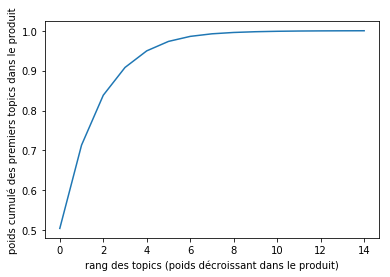

In [75]:
components = df_topics[col_names]

#tri des poids de chaque topic:
#initialisation:
coeffs_sorted = -np.sort(-components.loc[0])

#tri
for i in range(1,components.shape[0]):
    coeffs_sorted = np.vstack((coeffs_sorted, -np.sort(-components.iloc[i])))

#calcul des poids cumulés et agrégation:
cum_weights = np.cumsum(coeffs_sorted, axis=1)
total_cum_weights = np.sum(cum_weights, axis=0)/np.sum(cum_weights[:,num_topics-1])

#pour visualiser plus clairement, on se concentre sur les 100 mots principaux:
plt.plot(range(15),total_cum_weights[:15])
plt.xlabel('rang des topics (poids décroissant dans le produit)')
plt.ylabel('poids cumulé des premiers topics dans le produit')
plt.show()

On va appliquer la démarche suivante pour identifier les produits dont les topics sont trop peu concentrés :

On va considérer que chaque produit est caractérisé par un nombre faible de topics, qui n'est pas nécessairement le même pour tous les produits. Pour déterminer la liste de topics pour un produit considéré, on va parcourir la liste des poids des principaux topics du produit :

    - si le poids d'un topic est du même ordre de grandeur que le poids du top topic précédent (par exemple, s'il n'est pas inférieur à 25% du poids du top topic précédent), on l'ajoute à la liste des topics caractéristiques du mot
    - on s'arrête de parcourir la liste des top topics dès lors que le poids d'un topic est trop faible par rapport à celui du topic prédédent.
    
Pour déterminer le seuil sur les poids des topics, on entraînera enfin un modèle avec un train set dont on aura retiré les produits dont le nombre de topics pertinents est trop élevé (ie, compte tenu de la distribution des poids des topics vue plus haut, supérieur à 2 ou à 3).

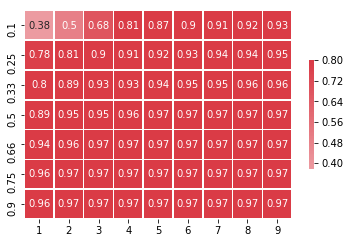

In [222]:
# on spécifie la liste des colonnes où sont stockés les produits
col_list = ['top_topic_' + str(i) + '_relative_weight' for i in range(1, 11)]

thresholds = [0.1, 0.25, 0.33, 0.5, 0.66, 0.75, 0.9]
max_nb_relevant_topics = range(1,10)
scores = np.zeros((len(thresholds), len(max_nb_relevant_topics)))

for i in range(len(thresholds)):
    threshold = thresholds[i]
    # on extrait, pour chaque produit, le nombre de topics pertinents
    df_topics['nb_relevant_topics'] = df_topics[col_list].apply(
        get_nb_relevant_items, args=([threshold]), axis=1)

    # on élimine les produits qui ont trop de dopics significatifs et on affiche l'impact sur la performance :

    for j in range(len(max_nb_relevant_topics)):
        element = max_nb_relevant_topics[j]
        prods_to_drop = df_topics[
            df_topics['nb_relevant_topics'] > element].index
        prods_to_drop = [k for k in Xtrain.index if k in prods_to_drop]
        Xtrain_red = Xtrain.drop(prods_to_drop)
        Ytrain_red = Ytrain.drop(prods_to_drop)
        etc = ExtraTreesClassifier(max_depth=100,
                                   random_state=42,
                                   n_estimators=2000,
                                   n_jobs=-1)
        etc.fit(Xtrain_red, Ytrain_red)
        scores[i, j] = etc.score(Xtest, Ytest)

# mise en forme des résultats dans un dataframe et affichage
scores = pd.DataFrame(scores, index=thresholds).rename(columns=
    dict(zip(range(len(max_nb_relevant_topics)), max_nb_relevant_topics))
)

sns.heatmap(scores, vmax=1, center=0,
            square=True, annot=True)

On observe ainsi qu'on peut obtenir des performances équivalentes à celles du modèle entraîné sur l'ensemble des données étiquetées, si on extrait du training set les produits ayant plus de 3 topics pertinents pour le seuil de 0.66.

In [228]:
df_topics['nb_relevant_topics'] = df_topics[col_list].apply(
        get_nb_relevant_items, args=([0.66]), axis=1)
diffuse_products = df_topics[
            df_topics['nb_relevant_topics'] > 3].index

Voyons si, après retrait de ces produits, certaines familles conservent des effectifs suffisants:

In [229]:
recap = df_topics.drop(diffuse_products, axis=0)
recap = recap.groupby('Product_family_innoscape').count()
min(recap.productfamily_seller)

17

Pas besoin de retirer davantage de familles. On peut entraîner le classifieur :

In [278]:
X_red = X.drop(diffuse_products)
Y_red = Y.drop(diffuse_products)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X_red,Y_red,test_size=0.2, random_state = 42, stratify=Y_red)
    
#entraînement d'un classifieur sur le train set et calcul du score
etc_red = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_red.fit(Xtrain,Ytrain)
score_red = etc_red.score(Xtest,Ytest)
print(score_red)

0.9734278122232064


On observe un gain de précision modéré.

Ce classifieur est-il efficace sur les produits qui ont été exclus du dataset?

In [231]:
Xval = df_topics.loc[diffuse_products,col_names]
Yval = df_topics.loc[diffuse_products,'Product_family_innoscape']
etc_red.score(Xval,Yval)

0.8957952468007313

#### 2- Retrait des topics diffus

In [281]:
frequent_topics2 = ['topic_'+str(t) for t in frequent_topics]
empty_topics2 = ['topic_'+str(t) for t in empty_topics]
diffuse_topics2 = ['topic_'+str(t) for t in diffuse_topics]

In [282]:
X_proj = X.drop(empty_topics2+diffuse_topics2, axis=1)
X_proj.shape

(6192, 189)

In [283]:
X_train, X_test, Ytrain, Ytest = train_test_split(X_proj,Y,test_size=0.2, random_state = 548, stratify=Y)

#entraînement d'un classifieur sur le train set et calcul du score
etc_proj = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc_proj.fit(X_train,Ytrain)
score_proj = etc_proj.score(X_test,Ytest)
print(score_proj)

0.9717514124293786


En ne conservant que les deux premiers topics:

In [307]:
df_topics2 = df_topics.copy().drop(['total_weights', 'top_topic_1', 'top_topic_1_relative_weight',
       'top_topic_2', 'top_topic_2_relative_weight', 'top_topic_3',
       'top_topic_3_relative_weight', 'top_topic_4',
       'top_topic_4_relative_weight', 'top1&2_weight'], axis=1)

In [320]:
col_names2 = [element for element in col_names if element not in empty_topics2+diffuse_topics2]
df_topics2 = df_topics2[col_names2]
total_weights = np.sum(df_topics2, axis=1)
df_topics2['total_weights'] = total_weights

In [345]:
#on réécrit légèrement les fonctions auxiliaires définies plus haut pour avoir les nouveaux top topics:
def get_top_topics2(row, cols_to_fetch, num_top_topics):
    top_topics_idx = np.argsort(-np.array(row[cols_to_fetch]))[:num_top_topics]
    top_topics = [int(element[6:]) for element in [cols_to_fetch[top_topics_idx[i]] for i in range(num_top_topics)]]
    top_topics_weights = row[['topic_'+str(element) for element in top_topics]].values
    return [top_topics,top_topics_weights]

In [351]:
df_topics2['top_top'] = df_topics2.apply(get_top_topics2, args=([col_names2,2]), axis=1)
df_topics2 = unpack_top_topics(df_topics2,'top_top','total_weights', 2)
df_topics2.drop('top_top', axis=1, inplace=True)
df_topics2.head()

topic_0  topic_1   topic_2   topic_4  topic_5  topic_7   topic_9  topic_10  \
0      0.0      0.0  0.005047  0.000000      0.0      0.0  0.000000       0.0   
3      0.0      0.0  0.005440  0.005141      0.0      0.0  0.000000       0.0   
4      0.0      0.0  0.000000  0.032532      0.0      0.0  0.040656       0.0   
6      0.0      0.0  0.008217  0.000000      0.0      0.0  0.000000       0.0   
7      0.0      0.0  0.006219  0.001678      0.0      0.0  0.000002       0.0   

   topic_11  topic_12  topic_14  topic_15  topic_16  topic_17  topic_18  \
0  0.000000       0.0       0.0       0.0  0.003488  0.000000       0.0   
3  0.025521       0.0       0.0       0.0  0.000000  0.000000       0.0   
4  0.000000       0.0       0.0       0.0  0.000000  0.000000       0.0   
6  0.000000       0.0       0.0       0.0  0.000000  0.041502       0.0   
7  0.065795       0.0       0.0       0.0  0.017514  0.000000       0.0   

   topic_21  topic_22  topic_23  topic_24  topic_25  topic_27  topic_29  \
0       0.0  0.000000       0.0       0.0       0.0       0.0  0.059302   
3       0.0  0.000000       0.0       0.0       0.0       0.0  0.062865   
4       0.0  0.000000       0.0       0.0       0.0       0.0  0.000000   
6       0.0  0.000036       0.0       0.0       0.0       0.0  0.000000   
7       0.0  0.000000       0.0       0.0       0.0       0.0  0.024126   

   topic_31  topic_32  topic_33  topic_34  topic_35  topic_36  topic_37  \
0       0.0       0.0       0.0       0.0  0.014522       0.0  0.000000   
3       0.0       0.0       0.0       0.0  0.027956       0.0  0.000000   
4       0.0       0.0       0.0       0.0  0.000000       0.0  0.035731   
6       0.0       0.0       0.0       0.0  0.000000       0.0  0.000000   
7       0.0       0.0       0.0       0.0  0.028535       0.0  0.000000   

   topic_38             ...               topic_166  topic_168  topic_171  \
0       0.0             ...                     0.0        0.0        0.0   
3       0.0             ...                     0.0        0.0        0.0   
4       0.0             ...                     0.0        0.0        0.0   
6       0.0             ...                     0.0        0.0        0.0   
7       0.0             ...                     0.0        0.0        0.0   

   topic_172  topic_173  topic_175  topic_176  topic_177  topic_180  \
0        0.0        0.0        0.0   0.000000        0.0        0.0   
3        0.0        0.0        0.0   0.000000        0.0        0.0   
4        0.0        0.0        0.0   0.000000        0.0        0.0   
6        0.0        0.0        0.0   0.000000        0.0        0.0   
7        0.0        0.0        0.0   0.010612        0.0        0.0   

   topic_181  topic_182  topic_183  topic_184  topic_185  topic_186  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   topic_187  topic_189  topic_190  topic_191  topic_192  topic_195  \
0        0.0        0.0        0.0        0.0        0.0        0.0   
3        0.0        0.0        0.0        0.0        0.0        0.0   
4        0.0        0.0        0.0        0.0        0.0        0.0   
6        0.0        0.0        0.0        0.0        0.0        0.0   
7        0.0        0.0        0.0        0.0        0.0        0.0   

   topic_196  topic_197  topic_198  topic_199  total_weights  top_topic_1  \
0        0.0        0.0        0.0        0.0       0.121218           29   
3        0.0        0.0        0.0        0.0       0.241810          132   
4        0.0        0.0        0.0        0.0       0.173393            9   
6        0.0        0.0        0.0        0.0       0.242287          146   
7        0.0        0.0        0.0

In [371]:
#retrait des produits dont seuls topics sont les topics diffus:
empty_products = df_topics2[df_topics2['total_weights']==0].index
empty_products.shape

(33,)

### Retrait de davantage de mots lors du preprocessing

On va essayer de retirer davantage de mots au cours du preprocessing, en retirant les mots contenus dans les topics qui n'ont pas d'utilité pratique pour la classification.

Pour cela, on définit un topic peu utile comme un topic qui n'apparaît dans les 3 principaux topics d'aucune famille de produits.

On rappelle les principaux topics par famille:

In [379]:
topics_by_fam[['top_topic_1','top_topic_1_relative_weight',
               'top_topic_2','top_topic_2_relative_weight',
              'top_topic_3','top_topic_3_relative_weight']].head(50)

top_topic_1  \
Product_family_innoscape                                          
accessoires chauffe-eau                                      12   
accessoires couverture                                       95   
accessoires et consommables outillage électropo...           57   
accessoires pour nettoyeur haute pression                    39   
accessoires pour outillage motorisé                          39   
ampoules et leds                                            175   
aménagements décoratifs                                      72   
anti-mousse                                                 154   
arrosage                                                    193   
aspirateurs, souffleurs, broyeurs                           103   
aérateur et vmc                                              91   
bardage                                                       4   
barre de seuil et nez de marche                              59   
batterie et chargeur                                         17   
brise-vue, canisse, brande, grillage et brise vent           58   
chauffage                                                   129   
chauffe-eau gaz                                             121   
chauffe-eau électrique                                       12   
conduit et accessoires d'aération                            20   
contenants                                                  169   
couverture                                                   14   
disjoncteur, coupe-circuit et interrupteur diff...          180   
divers                                                      134   
divers oep                                                  187   
débroussailleuse et coupe-bordures                           52   
défonceuse et lamelleuse et rabot                           148   
gouttière, descente et accessoires                            8   
grillage avertisseur et gaine de protection                   5   
mastic, colle, étanchéité                                    13   
meuleuse et rainureuse                                       32   
motobineuses et motoculteurs                                170   
mousse expansive                                            154   
outil motorisé modulable                                     39   
outillage à main                                             22   
outils multifonctions                                        37   
peinture                                                      6   
perceuse, perforateur et visseuse filaire                    27   
perceuse, perforateur et visseuse sans fil                   10   
pince et tenaille                                           184   
pistolet à colle et agrafeuse                               182   
plinthe bois, plinthe mdf, plinthe pvc                       28   
ponceuse électrique                                          33   
poudre béton, chaux, ciment, enduit, mortier, r...          136   
protection jardin, paillage, tuteurs et accesso...           63   
scies électriques                                            71   
taille-haies                                                 48   
tondeuses electriques, thermiques et autoportée               7   
tournevis (cruciforme, aimanté, de précision…)              162   
tronçonneuse, scie et fendeur de bois                        41   
vidage, bonde et siphon                                     172   

                                                    top_topic_1_relative_weight  \
Product_family_innoscape                                                          
accessoires chauffe-eau                                                0.462712   
accessoires couverture                                                 0.097392   
accessoires et consommables outillage électropo...                     0.102334   
accessoires pour nettoyeur haute pression                              0.123307   
accessoires pour outillage motorisé                                  

In [413]:
useful_topics = list(set(topics_by_fam.top_topic_1)|set(topics_by_fam.top_topic_2)|set(topics_by_fam.top_topic_3))
useless_topics = [k for k in range(200) if k not in useful_topics]

Parmi ces topics, voyons combien ne sont pas déjà inclus dans les topics vides ou les topics diffus:

In [387]:
useless_topics2 = [t for t in useless_topics if not t in list(empty_topics)+list(diffuse_topics)]
len(useless_topics2)

80

Voyons à présent le contenu d'un de ces topics, et si le vocabulaire associé est présent dans des topics utiles:

In [388]:
print('topic_'+str(useless_topics2[0])+':')
print(topic_description[useless_topics2[0]])
print('_'*30)

topic_0:
{'tuile': 14.01206177768503, 'ardoise': 0.8329045081181543, 'couverture': 0.2057697428547121, 'huguenot': 0.14627942567271582, 'meridional': 0.06443755274021197, 'delta': 0.04887780043567778}
______________________________


Prenons le premier mot du topic et voyons s'il se retrouve dans d'autres topics:

In [400]:
#voc_reverse
#voc
w_idx = voc['tuile']
w_idx

469

On liste les topics dans lesquels ce mot est présent et les poids associés:

In [405]:
topics_raw[:,w_idx]
w_present = [i for i in range(num_topics) if topics_raw[:,w_idx][i]>0]
w_weight = topics_raw[:,w_idx][w_present]

In [409]:
w_weight

array([1.40120618e+01, 3.02278380e-01, 7.05594487e-01, 3.17381258e-01,
       1.30992552e+00, 2.85176393e-01, 6.79259965e-01, 3.30370359e-01,
       9.58984168e-01, 9.84363055e-01, 1.45371218e-01, 2.63051449e-01,
       9.54015491e-01, 6.10951533e-01, 3.88485896e-01, 6.86850293e-02,
       4.79375115e-01, 1.77672213e-01, 1.74024426e-01, 1.11942587e+00,
       4.77273633e-02, 2.06797572e-01, 3.28723648e-01, 1.61877370e-01,
       2.97774430e-02, 3.83672513e-01, 1.14936214e-02, 5.67904622e-01,
       2.01246370e-01, 4.85604231e-02, 7.41147741e-02, 9.79489918e-02,
       3.93786220e-01, 2.25897801e-01, 5.46582009e+00, 9.48644173e-02,
       3.48866315e-01, 1.17338012e-04, 4.34999243e-01, 2.23966824e-01])

On constate que le mot 'tuile' est présent dans un grand nombre de topics. Pour déterminer s'il est réellement important ou non, on va examiner s'il est présent dans des topics jugés importants, avec un poids significatif. On définit pour cela une fonction qui extrait les principaux mots des topics importants:

In [417]:
def get_important_words(uselful_topics, importance_threshold):
    important_words = []
    for t in useful_topics:
        significant_words = [k for k,v in topic_description[t].items() \
                             if topic_description[t][k]>=importance_threshold]
        important_words += list(significant_words)
    
    return sorted(list(set(important_words)))

On extrait ensuite les composantes des topics peu importants:

In [419]:
def get_unimportant_words(useless_topics, importance_threshold=0):
    important_words = []
    for t in useful_topics:
        significant_words = [k for k,v in topic_description[t].items() \
                             if topic_description[t][k]>=importance_threshold]
        important_words += list(significant_words)
    
    return sorted(list(set(important_words)))

Pour finir, on crée une liste de stop words complémentaires en comparant les deux listes:

In [429]:
important_words = set(get_important_words(useful_topics, 1))
unimportant_words = set(get_unimportant_words(useless_topics,0))
additional_stopwords = sorted(list(unimportant_words-important_words))
additional_stopwords

['adjuver',
 'alde',
 'alimentation',
 'aluminium',
 'autre',
 'ballon',
 'blanc',
 'branche',
 'broyeur',
 'chaine',
 'choc',
 'cloture',
 'cm³',
 'colle',
 'compatible',
 'consommable',
 'coupe',
 'cuivrer',
 'decoratif',
 'delta',
 'disque',
 'embout',
 'essence',
 'extraction',
 'fibre',
 'filet',
 'finition',
 'flux',
 'fond',
 'huguenot',
 'huile',
 'humidite',
 'hydrofuge',
 'impermeabilisation',
 'instantane',
 'isoler',
 'jeu',
 'jonc',
 'lanterner',
 'liquide',
 'machiner',
 'marseille',
 'mat',
 'max',
 'modeler',
 'naissance',
 'nettoyer',
 'one',
 'oneplus',
 'onglet',
 'ovation',
 'pate',
 'pistolet',
 'plancher',
 'plaque',
 'plinthe',
 'pointe',
 'polyurethane',
 'pot',
 'primaire',
 'rac',
 'recuperation',
 'reparation',
 'rive',
 'rouleau',
 'sanitaire',
 'scier',
 'seau',
 'securite',
 'sikaflex',
 'special',
 'steatite',
 'stratifier',
 'support',
 'surface',
 'tampon',
 'tuteur',
 'vegetal',
 'vinyle',
 'voir',
 'xmm',
 'zinc']

On peut à présent sauvegarder ces nouveaux stop words et reprendre toute la démarche:

In [476]:
#copie des données
df_seller_bis = df_seller.copy()
nulls = df_seller_bis[df_seller_bis['concat'].isnull()].index
df_seller_bis.drop(nulls, axis=0, inplace=True)

#suppression des nouveaux stopwords dans les champs texte:
def clean_stop_words(x,stop_word_list):
    return ' '.join(list(set(x.split(' '))-set(stop_word_list)))

df_seller_bis['concat'] = df_seller_bis['concat'].apply(clean_stop_words, args=([additional_stopwords]))

In [477]:
#conversion en tf-idf et embedding
num_top_words = 500
vectorizer = TfidfVectorizer(max_features = num_top_words)
tf_idf_total2 = sparse.csr_matrix(vectorizer.fit_transform(df_seller_bis['concat']))
nmf2 = NMF(n_components=200, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tf_idf_total2)

In [481]:
#préparation du train set et du test set
X2 = pd.DataFrame(nmf2.transform(tf_idf_total2.todense())).set_index(df_seller_bis.index.values).loc[df_train_main_fams.index]
X2.rename(columns=dict(zip(range(200),['topic_'+str(i) for i in range(200)])),inplace=True)
Y2 = df_train_main_fams['Product_family_innoscape']

In [482]:
#train_test_split et entraînement d'un modèle
X2train, X2test, Y2train, Y2test = train_test_split(X2,Y2,test_size=0.2, random_state = 548)
etc2 = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc2.fit(X2train,Y2train)
etc2.score(X2test, Y2test)

0.9507667473769169

In [499]:
#même démarche en ne prenant que les 2 top topics
num_topics = 200
num_top_topics = 4
X2['total_weights'] = np.sum(X2, axis=1)
X2 = X2[X2['total_weights']>0]
X2['top_top'] = X2.apply(get_top_topics, args=([200,num_top_topics]), axis=1)
X2 = unpack_top_topics(X2,'top_top','total_weights', num_top_topics)
X2.drop('top_top', axis=1, inplace=True)

In [500]:
X2_top = X2[['top_topic_1',
            'top_topic_1_relative_weight',
            'top_topic_2','top_topic_2_relative_weight']]

In [501]:
X2train, X2test, Y2train, Y2test = train_test_split(X2_top,Y2,test_size=0.2, random_state = 548)
etc2_top = ExtraTreesClassifier(max_depth=100,random_state=42, n_estimators=2000,n_jobs=-1)
etc2_top.fit(X2train,Y2train)
etc2_top.score(X2test, Y2test)

0.8611783696529459

Conclusion : Retirer davantage de stop words au moment du preprocessing ne semble pas améliorer la performance du modèle. Ce n'est pas forcément surprenant, dans la mesure où un grand nombre de mots du vocabulaire total ont été retirés lors de la transformation tf-idf.